<h1 align="center">CS340 - Assignment 1</h1>
<h3 align="center">Due Date: 27 March 2017</h3>
<p style="text-indent: 40px">In this project we are going to simulate a hypothetical situation with <b>Spark</b>. Let's say we have 100x100 board similar to the bord above. A million times we throw three stones to the board.</p>

<div>
    <img src="http://image.prntscr.com/image/c577048a6cdf405990621e5b24bc1ade.png" width=200>

    <center><strong>Figure 1: 18x18 board</strong></center>
</div>

## Triangle or Not

<p style="text-indent: 40px">For the first part of this assignment you should calculate, out of those one million trials how many of them could form a triangle. The data is included in the assignment folder. Each row in the data represents a triangle and structure is like  "x1 y1, x2 y2, x3 y3" where x's and y's are the coordinates of the edges.</p>


<p style="text-indent: 40px"> Note: To check if a triangle is valid or not you should use <b>triangle inequality theorem</b>.</p>
<p style="text-indent: 40px"> Caution: Do not use loops or externmal libraries, you should only use <b>Spark</b>. Only library you can use for this project is matplotlib.</p>
<p style="text-indent: 40px">Important: <b>Plagiarism</b> will not be tolerated and issue will be referred to the <b>disciplinary committee</b>.</p>

In [1]:

# @hidden_cell
# This function is used to setup the access of Spark to your Object Storage. The definition contains your credentials.
# You might want to remove those credentials before you share your notebook.
def set_hadoop_config_with_credentials_3a500b3a65a940508dadf71c13437e1d(name):
    """This function sets the Hadoop configuration so it is possible to
    access data from Bluemix Object Storage using Spark"""

    prefix = 'fs.swift.service.' + name
    hconf = sc._jsc.hadoopConfiguration()
    hconf.set(prefix + '.auth.url', 'https://identity.open.softlayer.com'+'/v3/auth/tokens')
    hconf.set(prefix + '.auth.endpoint.prefix', 'endpoints')
    hconf.set(prefix + '.tenant', '266ba3381db2401faf8aaa2af05a9146')
    hconf.set(prefix + '.username', 'e6181ca8d25046b5a8f4ee43c04b79b8')
    hconf.set(prefix + '.password', 'qK-mWT(9O,q89]cY')
    hconf.setInt(prefix + '.http.port', 8080)
    hconf.set(prefix + '.region', 'dallas')
    hconf.setBoolean(prefix + '.public', False)

# you can choose any name
name = 'keystone'
set_hadoop_config_with_credentials_3a500b3a65a940508dadf71c13437e1d(name)

In [2]:
triangles = sc.textFile("swift://CS340." + name + "/triangles.csv")
# triangles = sc.textFile("swift://CS340." + name + "/triangles_mini.csv")
triangles.take(2)

[u'13 27, 68 55, 12 62', u'64 96, 91 62, 43 51']

In [3]:
distance_btw_2points = lambda x1,y1, x2,y2: ((x2-x1)**2+(y2-y1)**2)**0.5
def valid_triangle(x1,y1, x2,y2, x3,y3):
    a = distance_btw_2points (x1,y1, x2,y2)
    b = distance_btw_2points (x1,y1, x3,y3)
    c = distance_btw_2points (x2,y2, x3,y3)
    if a+b>c and a+c>b and b+c>a: return 1
    else: return 0

In [4]:
num_triangles = triangles .map(lambda x: [point.split(' ')[-2:] for point in x.split(',')])\
                          .map(lambda x: valid_triangle(int(x[0][0]), int(x[0][1]), int(x[1][0]), int(x[1][1]), int(x[2][0]), int(x[2][1])))\
                          .reduce(lambda x,y: x+y)
print num_triangles

999074


## Number of Neighbours
<p style="text-indent: 40px">For the next part of this project, you sohuld get the number of neighbours that each triangle(only valid traingles) has. Draw a histogram from those numbers with matplotlib library, number of bins shuld be 100 for the histogram. Then you should calculate the mean of the number of neighbours with <b>Spark</b>.</p>

<p style="text-indent: 40px"> For the simplicity, let's say that, if two triangles has a common vertex, they are neighbour.</p> 

In [5]:
# [((x1,y1),(x2,y2),(x3,y3))], (x1,y1),
# [((x1,y1),(x2,y2),(x3,y3))], (x2,y2),
# [((x1,y1),(x2,y2),(x3,y3))], (x3,y3)
# [triangle: point1, triangle:point2, triangle:point3]

valid_triangles = triangles .map(lambda x: [point.split(' ')[-2:] for point in x.split(',')])\
                            .map(lambda x: ((int(x[0][0]), int(x[0][1])), (int(x[1][0]), int(x[1][1])), (int(x[2][0]), int(x[2][1]))))\
                            .filter(lambda x: valid_triangle(x[0][0],x[0][1],x[1][0],x[1][1],x[2][0],x[2][1])==1)\
                            .map(lambda x:(x, x))\
                            .flatMapValues(lambda x:x)
hashed_valid_triangles = valid_triangles.map(lambda x: (x[1], hash(x[0])))
hashed_valid_triangles.take(3)

[((13, 27), -7835336301086972233),
 ((68, 55), -7835336301086972233),
 ((12, 62), -7835336301086972233)]

In [6]:
# valid_triangles.persist()
valid_triangles.take(3)

[(((13, 27), (68, 55), (12, 62)), (13, 27)),
 (((13, 27), (68, 55), (12, 62)), (68, 55)),
 (((13, 27), (68, 55), (12, 62)), (12, 62))]

In [7]:
# ((xi, yi), #of triangles sharing this vertex)
num_triangles_per_vertex = hashed_valid_triangles.groupByKey()
num_triangles_per_vertex.take(2)

[((50, 96), <pyspark.resultiterable.ResultIterable at 0x7fddb0508c10>),
 ((89, 11), <pyspark.resultiterable.ResultIterable at 0x7fddb0508210>)]

In [8]:
point_iterable_triangle = num_triangles_per_vertex.join(hashed_valid_triangles)  # (point, (iterable, triangle))
point_iterable_triangle.take(3)

[((50, 96),
  (<pyspark.resultiterable.ResultIterable at 0x7fddafa94b90>,
   -4921222113691954241)),
 ((50, 96),
  (<pyspark.resultiterable.ResultIterable at 0x7fddafa94d50>,
   6323402888982462760)),
 ((50, 96),
  (<pyspark.resultiterable.ResultIterable at 0x7fddafa94d50>,
   4459263232467715446))]

In [9]:
neighbors_per_triangle = point_iterable_triangle.map(lambda x: (x[1][1], list(x[1][0])))\
                                                .reduceByKey(lambda x,y: x+y)
neighbors_per_triangle.first()

(-9015289732761664428,
 [7838137071951012271,
  2595267199778705061,
  2248067707854964644,
  8817488456743057404,
  8715046472747404728,
  3636951883334742625,
  -8712193303593360441,
  -7470355222693002770,
  8777118461744106925,
  -5332001396434775538,
  -5844769575078434909,
  6862725174222680633,
  1356532519807296083,
  1689995802318614488,
  -9038453245838078041,
  2342958986314115824,
  3706658852807666313,
  443161645476088134,
  -6964097727925456566,
  -208989738294008130,
  -5996449784656897923,
  -4320833745997941500,
  -9026931147366349294,
  -193973419739511751,
  -2399549963038015345,
  -6359212197391339379,
  -2247328876325507086,
  -5529836710018421399,
  3021758245515219704,
  2802792646834038000,
  4578915807335430347,
  -1602454332846314411,
  195029515658188764,
  1054456616046646973,
  6351303802421098681,
  -3104986033344893628,
  1330040693750547754,
  2381279810721542781,
  5158329434216760358,
  -6093697136661454956,
  5202545818917736846,
  -11081873328185552

In [ ]:
num_neighbors_per_triangle = neighbors_per_triangle.mapValues(lambda x: len(set(x))-1)
num_neighbors_per_triangle.first()

(-8132272394985512960, 865)

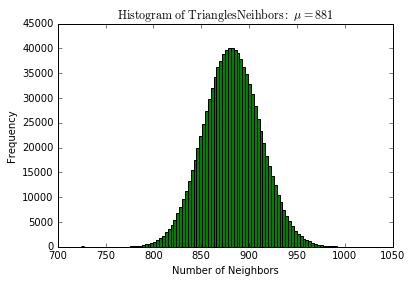

In [ ]:
# %matplotlib inline is a magic command that lets us draw graphs on the notebook
%matplotlib inline
import matplotlib.pyplot as plt

neighbors = num_neighbors_per_triangle.map(lambda x:x[1])
# neighbors.persist()

mean = neighbors.reduce(lambda x,y:x+y)/len(neighbors.collect())
n, bins, patches = plt.hist(neighbors.collect(), 100,facecolor='green')
plt.xlabel('Number of Neighbors')
plt.ylabel('Frequency')
plt.title(r'$\mathrm{Histogram\ of\ Triangles Neihbors:}\ \mu=%g$' %mean)
plt.show()

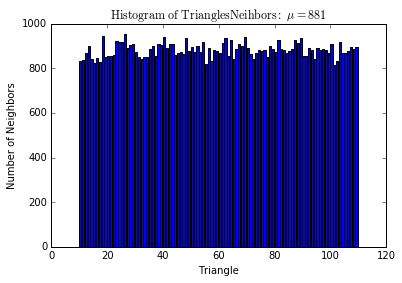

In [ ]:
plt.bar(range(10,110), neighbors.take(100))
plt.xlabel('Triangle')
plt.ylabel('Number of Neighbors')
plt.title(r'$\mathrm{Histogram\ of\ Triangles Neihbors:}\ \mu=%g$' %mean)
plt.show()

## Circumferences

<p style="text-indent: 40px">For the next part of this project you should calculate the circumferences of the triangles(only valid traingles). Then you should draw a <b>scatter plot</b> of "circumferences" and "number of neighbours". One caveat is that one million point is too much to draw, so take only ten thousand trianges that has the largest circumferences.</p>

In [ ]:
circumference = lambda x1,y1, x2,y2, x3,y3: (distance_btw_2points(x1,y1,x2,y2)+
                                             distance_btw_2points(x1,y1,x3,y3)+
                                            distance_btw_2points(x2,y2,x3,y3))

circumferences = valid_triangles.groupByKey()\
                                    .map(lambda x:(hash(x[0]), circumference(x[0][0][0], x[0][0][1],
                                                                             x[0][1][0], x[0][1][1],
                                                                             x[0][2][0], x[0][2][1])))

In [14]:
a = sc.parallelize([(1,2),(1,1)])
a.sortBy(lambda x:x[1], ascending=False).collect()

[(1, 2), (1, 1)]

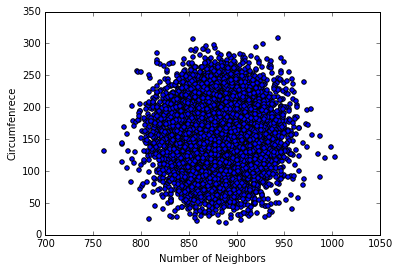

In [ ]:
neighbors_circumfereces = num_neighbors_per_triangle.join(circumferences)  # (triangle, (number of neighbors, circumference))
neighbors_circumfereces = neighbors_circumfereces.sortBy(lambda x:x[1][1], ascending=False)
neighbors_plot_array = neighbors_circumfereces.map(lambda x: x[1][0])
circumferences_plot_array = neighbors_circumfereces.map(lambda x: x[1][1])
# neighbors_plot_array.persist()
# circumferences_plot_array.persist()
plt.scatter(neighbors_plot_array.take(10000), circumferences_plot_array.take(10000))
plt.xlabel('Number of Neighbors')
plt.ylabel('Circumfenrece')
plt.show()